In [1]:
import banditpylib
import json
from matplotlib.pyplot import figure
from tabulate import tabulate

In [2]:
config_file = 'config.json'
# load config file
with open(config_file, 'r') as json_file:
    config = json.load(json_file)

In [3]:
# add `debug=True` in the arguments if you want more detailed runtime info or try to debug
# note that this feature may heavily increase the running time
data = banditpylib.run(config)

INFO:absl:run with goal Regret Minimization
INFO:absl:run Uniform Sampling with protocol SinglePlayerRegretMinProtocol
INFO:absl:1.93 seconds elapsed
INFO:absl:run UCB1 with protocol SinglePlayerRegretMinProtocol
INFO:absl:4.61 seconds elapsed
INFO:absl:run MOSS with protocol SinglePlayerRegretMinProtocol
INFO:absl:4.80 seconds elapsed
INFO:absl:run Thompson Sampling with protocol SinglePlayerRegretMinProtocol
INFO:absl:3.97 seconds elapsed


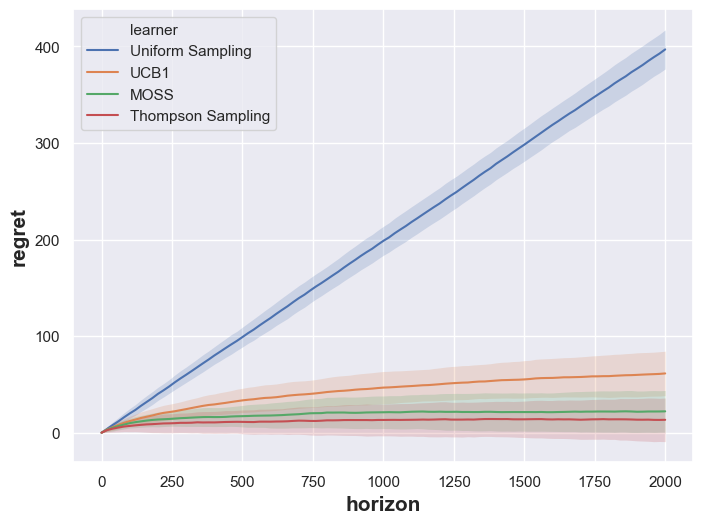

In [4]:
figure(figsize=(8, 6), dpi=100)
# add `save_fig=FILEPATH` in the arguments if you want to save the figure
df = banditpylib.plot(data, goal=config['learners']['goal'])

In [5]:
print(tabulate(df.head(), headers=["policy","regret"]))

policy          regret
------------  --------
('MOSS', 0)      0
('MOSS', 20)     3.22
('MOSS', 40)     5.11
('MOSS', 60)     6.94
('MOSS', 80)     8.435
